In [1]:
import json
import requests
import numpy as np
from matplotlib import pyplot as plt
import matplotlib
import matplotlib.patches as mpatches
import pandas as pd
import random
import glob
import zipfile
import os
import shutil

In [2]:
scenario_name = "hack fixed, twm, fixed long trips"
path_to_zip_file = '/home/ai6644/Malmo/Tools/Simulation results/Lolland/tw around departure, stretched, with transfers/'+\
                   scenario_name+'/log.zip'

scenario_name_pt = "only bus 2"
path_to_zip_file_pt = '/home/ai6644/Malmo/Tools/Simulation results/Lolland/tw around departure, stretched, with transfers/'+\
                   scenario_name_pt+'/log.zip'

In [3]:
day_sec = int(86400)
day_h = int(24)

In [4]:
with zipfile.ZipFile(path_to_zip_file, 'r') as zip_ref:
    try:
        shutil.rmtree('data/zip')
    except (FileNotFoundError, OSError) as e:
        pass
    os.mkdir('data/zip')
    zip_ref.extractall('data/zip')
path = 'data/zip/' + os.listdir('data/zip')[0] + '/trip_dump.json'
all_files = glob.glob("data/zip/*/vehicle_logs/vehicle_occupancy_*")
n_cars = len(all_files)
fp = open(path)
tdump = json.load(fp)
fp.close()

In [5]:
with zipfile.ZipFile(path_to_zip_file_pt, 'r') as zip_ref:
    try:
        shutil.rmtree('data/zip')
    except (FileNotFoundError, OSError) as e:
        pass
    os.mkdir('data/zip')
    zip_ref.extractall('data/zip')
path_pt = 'data/zip/' + os.listdir('data/zip')[0] + '/trip_dump.json'
fp_pt = open(path_pt)
tdump_pt = json.load(fp_pt)
fp.close()

In [6]:

class OtpMode(object):
    CAR = 'CAR'
    WALK = 'WALK'
    TRANSIT = 'TRANSIT,WALK'
    BUS = 'BUS,WALK'
    RAIL = 'TRAM,RAIL,SUBWAY,FUNICULAR,GONDOLA,WALK'
    BICYCLE = 'BICYCLE'
    BICYCLE_TRANSIT = 'TRANSIT,BICYCLE'
    PARK_RIDE = 'CAR_PARK,WALK,TRANSIT'
    KISS_RIDE = 'CAR,WALK,TRANSIT'
    BIKE_RIDE = 'BICYCLE_PARK,WALK,TRANSIT'
    RENTED_BICYCLE = 'WALK,BICYCLE_RENT'
    TRANSIT_RENTED_BICYCLE = 'TRANSIT,WALK,BICYCLE_RENT'
    DRT = 'DRT'
    DRT_TRANSIT = 'DRT_TRANSIT'

    _DICT = ['CAR', 'WALK', 'TRANSIT', 'BUS', 'RAIL', 'BICYCLE', 'BICYCLE_TRANSIT', 'PARK_RIDE', 'KISS_RIDE',
             'BIKE_RIDE', 'RENTED_BICYCLE', 'TRANSIT_RENTED_BICYCLE', 'DRT', 'DRT_TRANSIT']

    _MAIN_MODES = ['CAR', 'BICYCLE', 'TRANSIT', 'WALK']

    _DRT_MODES = ['DRT', 'DRT_TRANSIT']

    _PT_MODES = ['TRANSIT', 'BUS', 'RAIL']

    @staticmethod
    def get_all_modes():
        return [OtpMode.__dict__.get(item) for item in OtpMode._DICT]

    @staticmethod
    def get_main_modes():
        return [OtpMode.__dict__.get(item) for item in OtpMode._MAIN_MODES]

    @staticmethod
    def contains(other):
        return other in OtpMode._DICT

    @staticmethod
    def get_pt_modes():
        return OtpMode._PT_MODES

    @staticmethod
    def get_drt_modes():
        return OtpMode._DRT_MODES

    @staticmethod
    def get_mode(string):
        if OtpMode.contains(string):
            return OtpMode.__getattribute__(OtpMode(), string)
        else:
            raise Exception('unsupported mode {}'.format(string))


In [7]:
persons = tdump.get('person')
persons_pt = tdump_pt.get('person')

In [8]:
fp = open('data/population_lolland_4500.json')
tdump_pop = json.load(fp)
fp.close()
population = tdump_pop.get('persons')

# Deviation of actual trip start time to requested trip start time

In [9]:
perspop = []
for person in population:
    for activity in person['activities']:
        if activity['type'] == "WORK":
            t = sum([x*k for x,k in zip([int(t) for t in activity['end_time'].split(":")], [60*60, 60, 1])])
            perspop.append({'time_req': t, 'id': person['id']})

In [10]:
perstrips_drt = []
for person in persons:
    try:
        if person['actual_trips'][0]['main_mode'] in ['DRT']:
            perstrips_drt.append({'time_act': person['actual_trips'][0]['legs'][0]['start_time'], 'id': person['id']})
    except IndexError as e:
        print(person['id'])
        continue

935
2718
3895


In [11]:
perstrips_transit = []
for person in persons_pt:
    try:
        if person['actual_trips'][0]['main_mode'] in ['TRANSIT,WALK', 'WALK', 'TRANSIT']:
            perstrips_transit.append({'time_act': person['actual_trips'][0]['legs'][0]['start_time'], 'id': person['id']})
    except IndexError as e:
        print(person['id'])
        continue

935
2718
3895


In [12]:
times_drt = pd.concat([pd.DataFrame(perspop).set_index('id'), pd.DataFrame(perstrips_drt).set_index('id')], axis=1).dropna()
times_drt['diff'] = times_drt.time_req - times_drt.time_act

In [13]:
times_drt

,time_req,time_act,diff
id,,,
43,18108,16308.00,1800.00
75,18576,17223.50,1352.50
89,21337,19784.80,1552.20
96,21461,19844.80,1616.20
98,18457,16657.00,1800.00
...,...,...,...
4413,70658,68922.45,1735.55
4414,71640,69840.00,1800.00
4418,70412,70119.50,292.50


In [14]:
index = times_drt.index

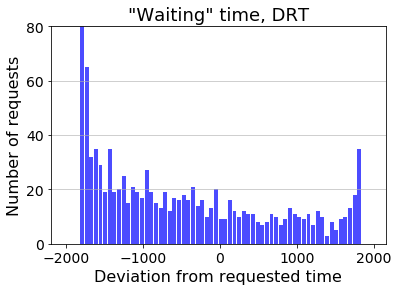

In [31]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.hist(x=times_drt['diff'], bins=np.arange(-2000,2000,60), color='blue', alpha=0.7, rwidth=0.85, density=False)

plt.grid(axis='y', alpha=0.75)
plt.xlabel('Deviation from requested time', {'fontsize': 16})
plt.ylabel('Number of requests', {'fontsize': 16})
plt.title('"Waiting" time, DRT', {'fontsize': 18})
plt.ylim([0,80])

plt.savefig('data/demand_distr.png', dpi=600)

In [16]:
times_transit = pd.concat([pd.DataFrame(perspop).set_index('id'), pd.DataFrame(perstrips_transit).set_index('id')], axis=1).dropna()
times_transit['diff'] = times_transit.time_req - times_transit.time_act
def strip_to_hour(seconds):
    """returns only hour from the time in seconds"""
    return int(seconds / 3600) * 3600
times_transit['time_req_strip'] = [strip_to_hour(t) for t in times_transit.time_req.values]
times_transit['diff2'] = times_transit.time_req_strip - times_transit.time_act

In [17]:
times_transit = times_transit.reindex(index=index).dropna()

In [18]:
times_transit

,time_req,time_act,diff,time_req_strip,diff2
id,,,,,
89,21337.0,20399.0,938.0,18000.0,-2399.0
96,21461.0,20399.0,1062.0,18000.0,-2399.0
112,19943.0,20640.0,-697.0,18000.0,-2640.0
114,18846.0,20460.0,-1614.0,18000.0,-2460.0
243,25091.0,25800.0,-709.0,21600.0,-4200.0
...,...,...,...,...,...
4397,69595.0,69900.0,-305.0,68400.0,-1500.0
4407,71618.0,70580.0,1038.0,68400.0,-2180.0
4413,70658.0,69780.0,878.0,68400.0,-1380.0


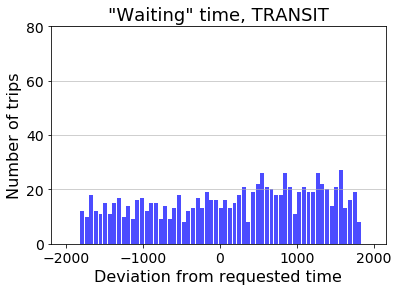

In [32]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.hist(x=times_transit['diff'], bins=np.arange(-2000,2000,60), color='blue', alpha=0.7, rwidth=0.85, density=False)

plt.grid(axis='y', alpha=0.75)
plt.xlabel('Deviation from requested time', {'fontsize': 16})
plt.ylabel('Number of trips', {'fontsize': 16})
plt.title('"Waiting" time, TRANSIT', {'fontsize': 18})
plt.ylim([0,80])

plt.savefig('data/demand_distr.png', dpi=600)

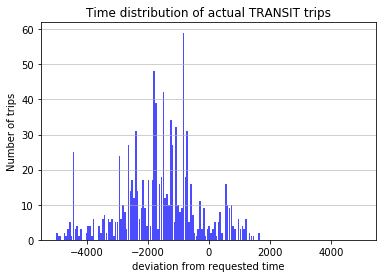

In [20]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.hist(x=times_transit['diff2'], bins=np.arange(-5000,5000,60), color='blue', alpha=0.7, rwidth=0.85, density=False)

plt.grid(axis='y', alpha=0.75)
plt.xlabel('deviation from requested time')
plt.ylabel('Number of trips')
plt.title('Time distribution of actual TRANSIT trips')

# plt.xticks([x*3600 for x in [0, 3, 6, 9, 12, 15, 18, 21, 24]])
# names_x = ['00:00','03:00','6:00','9:00','12:00','15:00','18:00','21:00', '24:00']
# ax.set_xticklabels(names_x,rotation=45)

plt.savefig('data/demand_distr.png', dpi=600)

# Distribution of trip time

In [47]:
direct_trips_drt = []
direct_trips_drt_transit = []
direct_trips_transit = []
drt_trips = []
drt_transit_trips = []
transit_trips = []

for person in persons:
    for actual_trip, direct_trip in zip(person.get('actual_trips'), person.get('direct_trips')):
        if actual_trip.get('main_mode') == OtpMode.DRT:
            direct_trips_drt.append(direct_trip)
            drt_trips.append(actual_trip)
        elif actual_trip.get('main_mode') == OtpMode.DRT_TRANSIT:
            direct_trips_drt_transit.append(direct_trip)
            drt_transit_trips.append(actual_trip)
        elif actual_trip['main_mode'] == OtpMode.TRANSIT:
            direct_trips_transit.append(direct_trip)
            transit_trips.append(actual_trip)

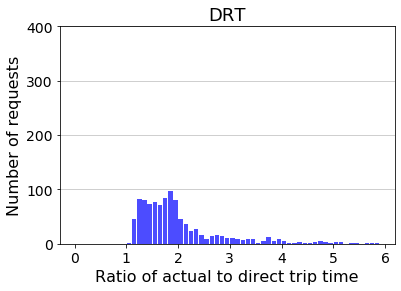

In [44]:
x = [at['duration']/dt['duration'] for dt,at in zip(direct_trips_drt, drt_trips)]

fig = plt.figure()
ax = fig.add_subplot(111)
ax.hist(x=x, bins=np.arange(0,6,0.1), color='blue', alpha=0.7, rwidth=0.85, density=False)

plt.grid(axis='y', alpha=0.75)
plt.xlabel('Ratio of actual to direct trip time', {'fontsize': 16})
plt.ylabel('Number of requests', {'fontsize': 16})
plt.title('DRT', {'fontsize': 18})
plt.ylim([0,400])

# plt.xticks([x*3600 for x in [0, 3, 6, 9, 12, 15, 18, 21, 24]])
# names_x = ['00:00','03:00','6:00','9:00','12:00','15:00','18:00','21:00', '24:00']
# ax.set_xticklabels(names_x,rotation=45)

plt.savefig('data/demand_distr.png', dpi=600)

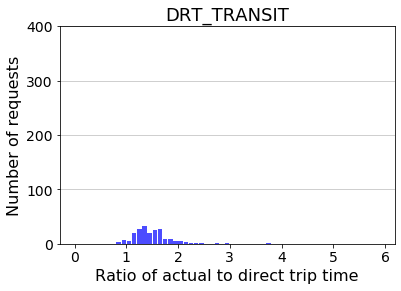

In [45]:
x = [at['duration']/dt['duration'] for dt,at in zip(direct_trips_drt_transit, drt_transit_trips)]

fig = plt.figure()
ax = fig.add_subplot(111)
ax.hist(x=x, bins=np.arange(0,6,0.1), color='blue', alpha=0.7, rwidth=0.85, density=False)

plt.grid(axis='y', alpha=0.75)
plt.xlabel('Ratio of actual to direct trip time', {'fontsize': 16})
plt.ylabel('Number of requests', {'fontsize': 16})
plt.title('DRT_TRANSIT', {'fontsize': 18})
plt.ylim([0,400])

# plt.xticks([x*3600 for x in [0, 3, 6, 9, 12, 15, 18, 21, 24]])
# names_x = ['00:00','03:00','6:00','9:00','12:00','15:00','18:00','21:00', '24:00']
# ax.set_xticklabels(names_x,rotation=45)

plt.savefig('data/demand_distr.png', dpi=600)

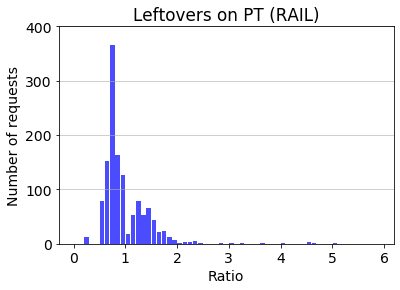

In [48]:
x = [at['duration']/dt['duration'] for dt,at in zip(direct_trips_transit, transit_trips)]

fig = plt.figure()
ax = fig.add_subplot(111)
ax.hist(x=x, bins=np.arange(0,6,0.1), color='blue', alpha=0.7, rwidth=0.85, density=False)

plt.grid(axis='y', alpha=0.75)
plt.xlabel('Ratio')
plt.ylabel('Number of requests')
plt.title('Leftovers on PT (RAIL)')
plt.ylim([0,400])

# plt.xticks([x*3600 for x in [0, 3, 6, 9, 12, 15, 18, 21, 24]])
# names_x = ['00:00','03:00','6:00','9:00','12:00','15:00','18:00','21:00', '24:00']
# ax.set_xticklabels(names_x,rotation=45)

plt.savefig('data/demand_distr.png', dpi=600)

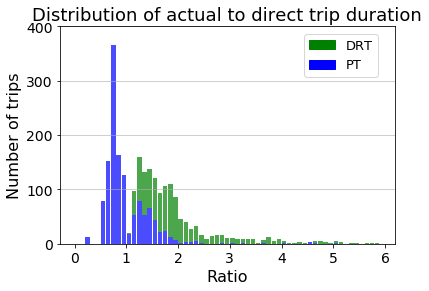

In [24]:
font = {'size': 14}
matplotlib.rc('font', **font)

x = [at['duration']/dt['duration'] for dt,at in zip(direct_trips_drt, drt_trips)]

fig = plt.figure()
ax = fig.add_subplot(111)
# ax.hist(x=x, bins=np.arange(0,6,0.1), color='green', alpha=1.0, rwidth=0.85, density=False, stacked=True)

x2 = [at['duration']/dt['duration'] for dt,at in zip(direct_trips_transit, transit_trips)]
ax.hist(x=[x2,x], bins=np.arange(0,6,0.1), color=['blue', 'green'], alpha=0.7, rwidth=0.85, density=False, stacked=True)

plt.grid(axis='y', alpha=0.75)
plt.xlabel('Ratio', {'fontsize': 16})
plt.ylabel('Number of trips', {'fontsize': 16})
plt.title('Distribution of actual to direct trip duration', {'fontsize': 18})
plt.ylim(0,400)

labels = ['DRT', 'PT']
colours = ['green','blue']
leg = [mpatches.Patch(color=c, label=l) for l,c in zip(labels,colours)]
plt.legend(handles=leg, bbox_to_anchor=(0.97, 0.995), fontsize=13)

plt.savefig('data/sim_mult_distr.png', dpi=600, bbox_inches="tight")

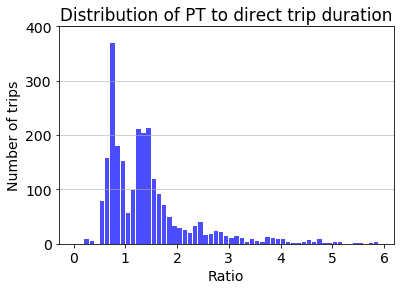

In [27]:
font = {'size': 14}
matplotlib.rc('font', **font)

fig = plt.figure()
ax = fig.add_subplot(111)
ax.hist(x=x, bins=np.arange(0,6,0.1), color='blue', alpha=0.7, rwidth=0.85, density=False)

plt.grid(axis='y', alpha=0.75)
plt.xlabel('Ratio')
plt.ylabel('Number of trips')
plt.title('Distribution of PT to direct trip duration')

# plt.xticks([x*3600 for x in [0, 3, 6, 9, 12, 15, 18, 21, 24]])
# names_x = ['00:00','03:00','6:00','9:00','12:00','15:00','18:00','21:00', '24:00']
# ax.set_xticklabels(names_x,rotation=45)
plt.ylim(0,400)

plt.savefig('data/pt_multiplier_distr.png', dpi=600, bbox_inches="tight")

### now for PT only

In [49]:
direct_trips_transit = []
transit_trips = []

for person in persons_pt:
    for actual_trip, direct_trip in zip(person.get('actual_trips'), person.get('direct_trips')):
        if actual_trip['main_mode'] == OtpMode.TRANSIT:
            direct_trips_transit.append(direct_trip)
            transit_trips.append(actual_trip)

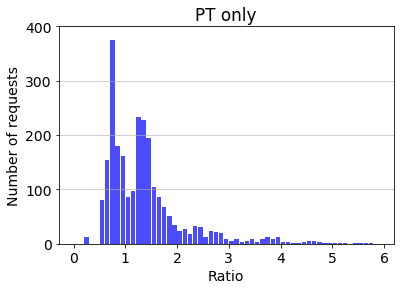

In [50]:
x = [at['duration']/dt['duration'] for dt,at in zip(direct_trips_transit, transit_trips)]

fig = plt.figure()
ax = fig.add_subplot(111)
ax.hist(x=x, bins=np.arange(0,6,0.1), color='blue', alpha=0.7, rwidth=0.85, density=False)

plt.grid(axis='y', alpha=0.75)
plt.xlabel('Ratio')
plt.ylabel('Number of requests')
plt.title('PT only')
plt.ylim([0,400])

# plt.xticks([x*3600 for x in [0, 3, 6, 9, 12, 15, 18, 21, 24]])
# names_x = ['00:00','03:00','6:00','9:00','12:00','15:00','18:00','21:00', '24:00']
# ax.set_xticklabels(names_x,rotation=45)

plt.savefig('data/demand_distr.png', dpi=600)